In [2]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import time

In [3]:
# zf = zipfile.ZipFile('../Data/nhanes_labs2.zip')
# if zipped use zf.open('nhanes_labs2.csv')
df = pd.read_csv('Data/nhanes_labs2.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (60,61,63,276) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Set the age range (see paper for the age ranges we used)
cohort = df[(df.RIDAGEYR >= 1) & (df.RIDAGEYR <= 85)]

In [5]:
thresh = len(cohort) * 0.05
cohort = cohort.dropna(thresh=thresh, axis = 1)
thresh2 = 20
cohort = cohort.dropna(thresh=thresh2, axis=0)

In [6]:
cohort.shape

(67563, 364)

In [7]:
from sklearn.model_selection import train_test_split
y = cohort["RIDAGEYR"]
# Remove unused variables and duplicates
X =  cohort.drop(["RIDAGEYR", "WTMEC2YR","SDDSRVYR", "RIDRETH1", "RIAGENDR", "INDFMPIR",
                "LBXINSI", "LBXGLUSI"], axis=1)
# For the 18-44 cohort, the variable "LBXBVPH" must also be dropped. In other cohorts, the variables "LBXINSI" and 
# "LBXGLUSI" may not be in the list depending on filtering criteria.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

my_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())
])
X_train = my_pipeline.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = my_pipeline.transform(X_test)

In [9]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("stdv:", scores.std())

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
   {
    'n_estimators': [25, 50, 100, 200, 400,500],
    'max_features': [1, 5, 10, 25, 50, 100]
    'boostrap': [True, False]
    }
]

forest_reg = RandomForestRegressor()
grid_search = RandomizedSearchCV(forest_reg, param_grid , cv = 5,
                                scoring='neg_mean_squared_error', n_iter=5,
                                n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [10]:
start_time = time.time()
forest_reg = RandomForestRegressor(n_estimators=200, n_jobs=-1, max_features=50, bootstrap=True)
forest_reg.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 36.77184343338013 seconds ---


In [ ]:
from sklearn.model_selection import cross_val_score
start_time = time.time()
score = cross_val_score(forest_reg, X_train, y_train,
                         scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
forest_mae_scores = -score
display_scores(forest_mae_scores)
print("--- %s seconds ---" % (time.time() - start_time))

In [11]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, forest_reg.predict(X_test))

4.763168430400355

In [12]:
from sklearn.metrics import r2_score
r2_score(y_test, forest_reg.predict(X_test))

0.9218780948657412

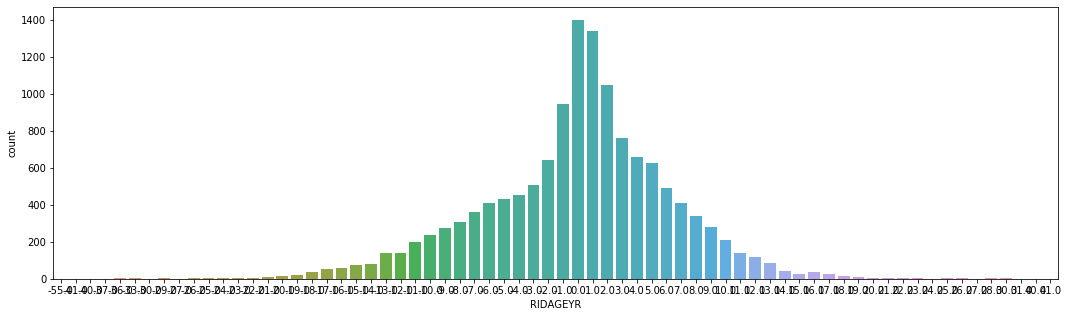

In [13]:
forest_preds = forest_reg.predict(X_test)
actuals = y_test
resids = forest_preds - actuals
plt.figure(figsize=(18,5))
sns.countplot(resids.round());

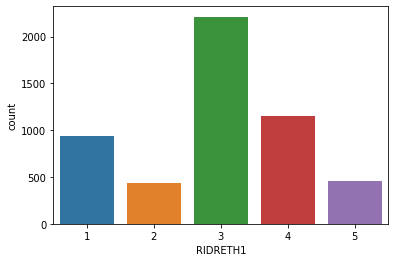

In [14]:
sns.countplot(cohort.loc[(resids[((resids < -5) | (resids > 5))]).index].RIDRETH1);

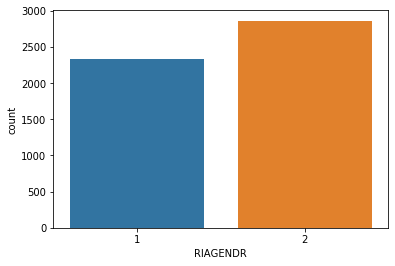

In [15]:
sns.countplot(cohort.loc[(resids[((resids < -5) | (resids > 5))]).index].RIAGENDR);

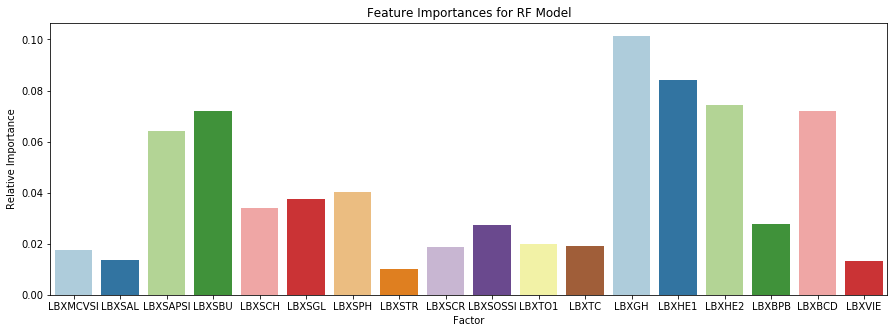

In [16]:
varimp = []
for name, score in zip(X.columns, forest_reg.feature_importances_):
    if score >= 0.01:
        varimp.append((name, score))

varimpdf = pd.DataFrame(varimp)

d = {'Factor': varimpdf[0], 'Relative Importance': varimpdf[1]}
varimps = pd.DataFrame(data=d)

plt.figure(figsize=(15,5))
plt.title("Feature Importances for RF Model")
sns.barplot(x = varimps.Factor, y=varimps['Relative Importance'], palette='Paired');

In [17]:
varimps.sort_values(by = 'Relative Importance', ascending=False)

,Factor,Relative Importance
12,LBXGH,0.101379
13,LBXHE1,0.084147
14,LBXHE2,0.074189
3,LBXSBU,0.072151
16,LBXBCD,0.072076
2,LBXSAPSI,0.064256
6,LBXSPH,0.040112
5,LBXSGL,0.037709
4,LBXSCH,0.034079
15,LBXBPB,0.027729


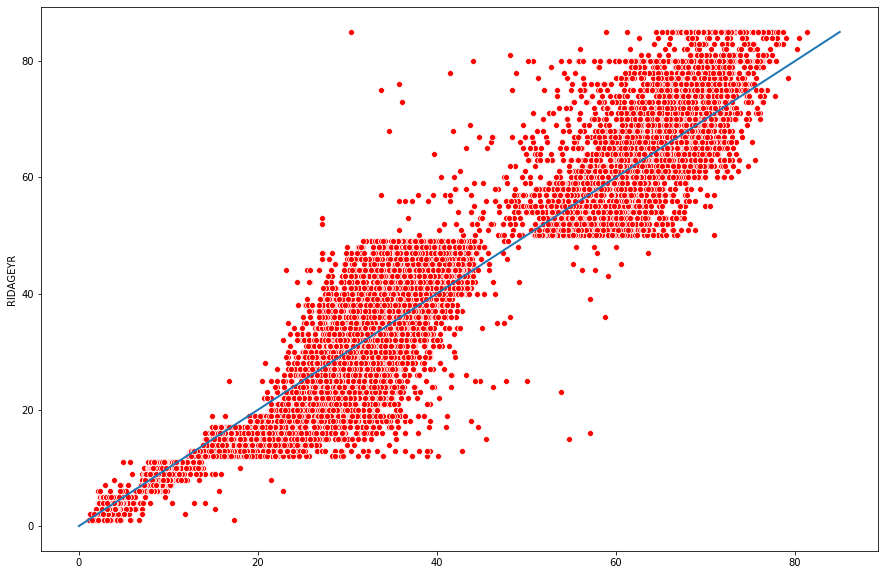

In [18]:
plt.figure(figsize=(15, 10));
sns.scatterplot(x=forest_reg.predict(X_test), y=y_test, color="red");
plt.plot([0, 85], [0, 85], linewidth=2);